In [4]:
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# import pollock
# from pollock import PollockDataset, PollockModel, load_from_directory

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [5]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [6]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [7]:
snRNA_anndata_fp = '/data/single_cell_classification/tumor/BR/snRNA/merged.h5ad'
snATAC_anndata_fp = '/data/single_cell_classification/tumor/BR/snATAC/merged.h5ad'

In [8]:
snRNA_adata = sc.read_h5ad(snRNA_anndata_fp)
snRNA_adata = snRNA_adata[snRNA_adata.obs['orig.ident']=='TWCE-HT088B1-Bc3']
snRNA_adata

View of AnnData object with n_obs × n_vars = 970 × 16153 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident'
    layers: 'logcounts'

In [9]:
snATAC_adata = sc.read_h5ad(snATAC_anndata_fp)
snATAC_adata.obs['cell_type'] = list(snATAC_adata.obs['predicted.id'])
snATAC_adata

AnnData object with n_obs × n_vars = 8474 × 19779 
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_group', 'TSS.enrichment', 'high.tss', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Endothelial', 'prediction.score.CD8_T', 'prediction.score.CD4_T', 'prediction.score.Fibroblast', 'prediction.score.Plasma', 'prediction.score.Macrophage', 'prediction.score.NK', 'prediction.score.Mast', 'prediction.score.max', 'ident', 'cell_type'
    layers: 'logcounts'

In [10]:
snRNA_adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,cell_type,ident
index,,,,,,,,,,
TWCE-HT088B1-Bc3_AAACCCAAGAGATCGC-1,TWCE-HT088B1-Bc3,5761.0,1947,0.045652,3527.0,1798,1,1,Tumor,Tumor
TWCE-HT088B1-Bc3_AAACCCAAGGTTCTTG-1,TWCE-HT088B1-Bc3,3636.0,1386,0.059956,3146.0,1376,6,6,Tumor,Tumor
TWCE-HT088B1-Bc3_AAACGCTTCCTCAGAA-1,TWCE-HT088B1-Bc3,5009.0,1975,0.083849,3393.0,1918,0,0,Endothelial,Endothelial
TWCE-HT088B1-Bc3_AAAGGATAGTGCTCGC-1,TWCE-HT088B1-Bc3,1232.0,592,0.093344,2502.0,623,10,10,Tumor,Tumor
TWCE-HT088B1-Bc3_AAAGGGCCAACTCCAA-1,TWCE-HT088B1-Bc3,10777.0,3365,0.063376,2953.0,1472,0,0,Endothelial,Endothelial
...,...,...,...,...,...,...,...,...,...,...
TWCE-HT088B1-Bc3_TTTCCTCAGCCGAACA-1,TWCE-HT088B1-Bc3,1345.0,664,0.033457,2547.0,669,3,3,CD4_T,CD4_T
TWCE-HT088B1-Bc3_TTTCCTCGTGGATCGA-1,TWCE-HT088B1-Bc3,4071.0,1477,0.077868,3254.0,1469,11,11,Macrophage,Macrophage
TWCE-HT088B1-Bc3_TTTGACTTCGGCTTGG-1,TWCE-HT088B1-Bc3,2596.0,1021,0.082049,2708.0,1017,1,1,Tumor,Tumor


In [11]:
snATAC_adata.obs

,orig.ident,nCount_peaks,nFeature_peaks,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,prediction.score.CD8_T,prediction.score.CD4_T,prediction.score.Fibroblast,prediction.score.Plasma,prediction.score.Macrophage,prediction.score.NK,prediction.score.Mast,prediction.score.max,ident,cell_type
index,,,,,,,,,,,,,,,,,,,,,
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_CGCAATAGTTCCATCC-1,ATAC,6796.0,3018,10044,1954,121,67,1152,38,6712,...,0.005379,0.036888,0.000000,0.000000,0.012197,0.006326,0.000000,0.939209,2,Tumor
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_GTAGTACGTTGCTTGA-1,ATAC,5696.0,2633,9704,1554,99,80,682,134,7155,...,0.000000,0.004065,0.930636,0.000000,0.000000,0.000000,0.000000,0.930636,1,Fibroblast
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_GTTATTCTCTACATCT-1,ATAC,7776.0,3136,13915,2777,203,113,1044,23,9755,...,0.018184,0.273866,0.000000,0.001137,0.009159,0.011332,0.686323,0.686323,6,Mast
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_CGCGCAATCTGGAAGG-1,ATAC,21026.0,8511,28326,4851,348,242,1910,55,20920,...,0.000000,0.000000,0.056559,0.011413,0.027084,0.000000,0.000000,0.904944,0,Tumor
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_GGGAACAAGCTTCAAC-1,ATAC,10525.0,4547,27690,5266,362,163,3470,454,17975,...,0.000000,0.079488,0.183399,0.014177,0.000000,0.000000,0.000000,0.722936,2,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H2A2Y1N1_CATGCCTCAAGGCGTA-1,ATAC,2816.0,1316,11217,1965,138,101,1086,12,7915,...,0.400309,0.304507,0.000000,0.032088,0.006249,0.256847,0.000000,0.400309,5,CD8_T
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H2A2Y1N1_TCACCTGAGTGCAACG-1,ATAC,8268.0,3843,15832,3600,132,187,1159,94,10660,...,0.000000,0.000000,0.999737,0.000000,0.000000,0.000000,0.000000,0.999737,2,Fibroblast
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H2A2Y1N1_TGAGCCGAGTTGAATG-1,ATAC,7035.0,3379,12720,1957,98,166,1279,1107,8113,...,0.000000,0.002708,0.064056,0.018743,0.000000,0.000000,0.000000,0.808545,1,Tumor


In [12]:
sc.pp.normalize_total(snRNA_adata, target_sum=1e6)
sc.pp.log1p(snRNA_adata)
snRNA_adata.raw = snRNA_adata

/miniconda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [13]:
sc.pp.normalize_total(snATAC_adata, target_sum=1e6)
sc.pp.log1p(snATAC_adata)
snATAC_adata.raw = snATAC_adata

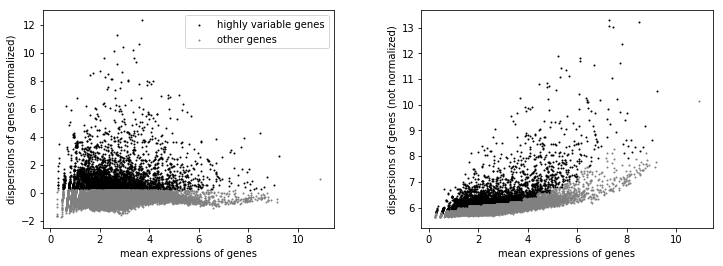

In [14]:
sc.pp.highly_variable_genes(snRNA_adata, min_mean=0.0, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(snRNA_adata)

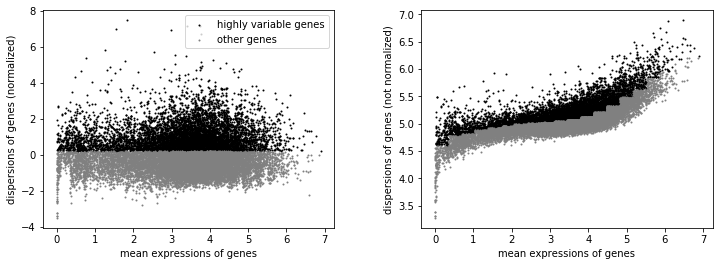

In [15]:
sc.pp.highly_variable_genes(snATAC_adata, min_mean=0.0, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(snATAC_adata)

In [16]:
a = set(snRNA_adata.var.index)
b = set(snATAC_adata.var.index)
s = a.intersection(b)
len(s)

13936

In [17]:
snRNA_adata = snRNA_adata[:, sorted(s)]
snATAC_adata = snATAC_adata[:, sorted(s)]

In [18]:
Counter(snRNA_adata.obs['cell_type']).most_common()

[('Tumor', 302),
 ('Endothelial', 225),
 ('Fibroblast', 195),
 ('Macrophage', 110),
 ('CD4_T', 66),
 ('Plasma', 22),
 ('CD8_T', 21),
 ('Mast', 16),
 ('NK', 13)]

In [19]:
Counter(snATAC_adata.obs['cell_type']).most_common()

[('Tumor', 5694),
 ('Fibroblast', 1696),
 ('Endothelial', 361),
 ('Macrophage', 351),
 ('CD4_T', 176),
 ('CD8_T', 74),
 ('Mast', 71),
 ('Plasma', 47),
 ('NK', 4)]

In [20]:
snRNA_adata.obs['dataset'] = 'snRNA'
snATAC_adata.obs['dataset'] = 'snATAC'

combined_adata = snRNA_adata.concatenate(snATAC_adata)
combined_adata

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 9444 × 13936 
    obs: 'DNase_sensitive_region_fragments', 'SCT_snn_res.0.5', 'TSS.enrichment', 'TSS_fragments', 'batch', 'blacklist_ratio', 'blacklist_region_fragments', 'cell_id', 'cell_type', 'chimeric', 'dataset', 'duplicate', 'enhancer_region_fragments', 'high.tss', 'ident', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'nCount_ACTIVITY', 'nCount_RNA', 'nCount_SCT', 'nCount_peaks', 'nFeature_ACTIVITY', 'nFeature_RNA', 'nFeature_SCT', 'nFeature_peaks', 'nucleosome_group', 'nucleosome_percentile', 'nucleosome_signal', 'on_target_fragments', 'orig.ident', 'passed_filters', 'pct_reads_in_peaks', 'peak_region_cutsites', 'peak_region_fragments', 'peaks_snn_res.0.8', 'percent.mito', 'predicted.id', 'prediction.score.CD4_T', 'prediction.score.CD8_T', 'prediction.score.Endothelial', 'prediction.score.Fibroblast', 'prediction.score.Macrophage', 'prediction.score.Mast', 'prediction.score.NK', 'prediction.score.Plasma', 'prediction.score.Tumor', 'predict

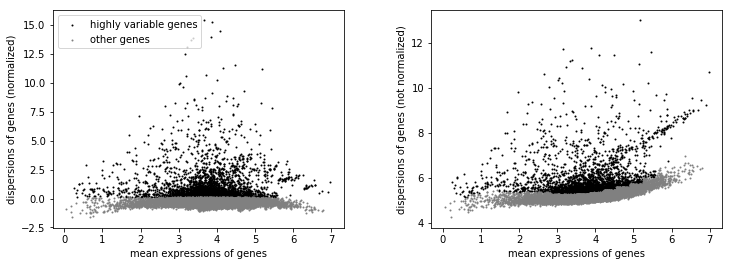

In [21]:
sc.pp.highly_variable_genes(combined_adata, min_mean=0.0, max_mean=10., min_disp=0.1)
sc.pl.highly_variable_genes(combined_adata)

In [22]:
# np.count_nonzero(combined_adata.var.highly_variable)

In [23]:
sc.pp.scale(combined_adata, max_value=None)
combined_adata

AnnData object with n_obs × n_vars = 9444 × 13936 
    obs: 'DNase_sensitive_region_fragments', 'SCT_snn_res.0.5', 'TSS.enrichment', 'TSS_fragments', 'batch', 'blacklist_ratio', 'blacklist_region_fragments', 'cell_id', 'cell_type', 'chimeric', 'dataset', 'duplicate', 'enhancer_region_fragments', 'high.tss', 'ident', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'nCount_ACTIVITY', 'nCount_RNA', 'nCount_SCT', 'nCount_peaks', 'nFeature_ACTIVITY', 'nFeature_RNA', 'nFeature_SCT', 'nFeature_peaks', 'nucleosome_group', 'nucleosome_percentile', 'nucleosome_signal', 'on_target_fragments', 'orig.ident', 'passed_filters', 'pct_reads_in_peaks', 'peak_region_cutsites', 'peak_region_fragments', 'peaks_snn_res.0.8', 'percent.mito', 'predicted.id', 'prediction.score.CD4_T', 'prediction.score.CD8_T', 'prediction.score.Endothelial', 'prediction.score.Fibroblast', 'prediction.score.Macrophage', 'prediction.score.Mast', 'prediction.score.NK', 'prediction.score.Plasma', 'prediction.score.Tumor', 'predict

In [24]:
sc.tl.pca(combined_adata, svd_solver='arpack')
sc.pp.neighbors(combined_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(combined_adata)

In [25]:
def cap_list(ls, n=100, hard_cap=False):
    if len(ls) > n:
        return random.sample(ls, n)
    if hard_cap:
        return ls
    return random.sample(ls, int(len(ls) * .8))


def get_balanced_ids(adata, key, n_per_cell_type, hard_cap=False):
    cell_type_to_idxs = {}
    for cell_id, cell_type in zip(adata.obs.index, adata.obs[key]):
        if cell_type not in cell_type_to_idxs:
            cell_type_to_idxs[cell_type] = [cell_id]
        else:
            cell_type_to_idxs[cell_type].append(cell_id)

    cell_type_to_idxs = {k:cap_list(ls, n_per_cell_type, hard_cap=hard_cap)
                        for k, ls in cell_type_to_idxs.items()}

    train_ids = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
    val_ids = np.asarray(list(set(adata.obs.index) - set(train_ids)))
    
    return train_ids, val_ids

def grab_n(adata, key, n_per_cell_type):
    train_ids, _ = get_balanced_ids(adata, key, n_per_cell_type, hard_cap=True)
    return adata[train_ids].X


In [26]:

snRNA_train_ids, snRNA_val_ids = get_balanced_ids(combined_adata[combined_adata.obs['dataset']=='snRNA'],
                                               'cell_type', 200)

snATAC_train_ids, snATAC_val_ids = get_balanced_ids(combined_adata[combined_adata.obs['dataset']=='snATAC'],
                                               'cell_type', 200)

train_ids = np.concatenate((snRNA_train_ids, snATAC_train_ids))
val_ids = np.concatenate((snRNA_val_ids, snATAC_val_ids))

train_adata = combined_adata[train_ids].copy()
val_adata = combined_adata[val_ids].copy()

In [27]:
from sklearn.preprocessing import MaxAbsScaler
X_train = train_adata.X
X_val = val_adata.X

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((1846, 13936), (7598, 13936))

In [28]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [29]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [30]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + (alpha * kl_loss))
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [31]:
# epochs = 250
# latent_dim = 100
# # alpha = 0.1
# alpha = 2.

epochs = 100
latent_dim = 75
# alpha = 0.1
alpha = 3

model = BVAE(latent_dim, X_train.shape[1])

In [32]:
vals = grab_n(val_adata, 'cell_type', 10)
vals = tf.data.Dataset.from_tensor_slices(vals).batch(BATCH_SIZE)

In [33]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
#     for test_x in test_dataset:
    for test_x in vals:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {loss.result()}')

epoch: 1, val loss: 6694.67236328125
epoch: 2, val loss: 6573.3134765625
epoch: 3, val loss: 6520.59130859375
epoch: 4, val loss: 6401.876953125
epoch: 5, val loss: 6394.36328125
epoch: 6, val loss: 6403.892578125
epoch: 7, val loss: 6394.59814453125
epoch: 8, val loss: 6357.43798828125
epoch: 9, val loss: 6353.6298828125
epoch: 10, val loss: 6328.919921875
epoch: 11, val loss: 6331.7275390625
epoch: 12, val loss: 6325.4912109375
epoch: 13, val loss: 6319.0546875
epoch: 14, val loss: 6304.8076171875
epoch: 15, val loss: 6314.8798828125
epoch: 16, val loss: 6294.13037109375
epoch: 17, val loss: 6274.5703125
epoch: 18, val loss: 6277.494140625
epoch: 19, val loss: 6265.49609375
epoch: 20, val loss: 6259.7333984375
epoch: 21, val loss: 6246.57275390625
epoch: 22, val loss: 6241.16796875
epoch: 23, val loss: 6230.744140625
epoch: 24, val loss: 6239.07666015625
epoch: 25, val loss: 6237.6669921875
epoch: 26, val loss: 6233.50927734375
epoch: 27, val loss: 6230.59716796875
epoch: 28, val los

In [34]:
cell_embeddings = None
for i in range(0, combined_adata.X.shape[0], 1000):
    

    mean, logvar = model.encode(combined_adata.X[i:i+1000])
    
    if cell_embeddings is None:
        cell_embeddings = model.reparameterize(mean, logvar).numpy()
    else:
        cell_embeddings = np.concatenate((cell_embeddings, model.reparameterize(mean, logvar).numpy()), axis=0)
cell_embeddings.shape

(9444, 75)

In [35]:
import umap
combined_adata.obsm['cell_embeddings'] = cell_embeddings
combined_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(combined_adata.obsm['cell_embeddings'])
combined_adata.obs['cell_embedding_umap1'] = combined_adata.obsm['cell_embedding_umap'][:, 0]
combined_adata.obs['cell_embedding_umap2'] = combined_adata.obsm['cell_embedding_umap'][:, 1]

combined_adata

AnnData object with n_obs × n_vars = 9444 × 13936 
    obs: 'DNase_sensitive_region_fragments', 'SCT_snn_res.0.5', 'TSS.enrichment', 'TSS_fragments', 'batch', 'blacklist_ratio', 'blacklist_region_fragments', 'cell_id', 'cell_type', 'chimeric', 'dataset', 'duplicate', 'enhancer_region_fragments', 'high.tss', 'ident', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'nCount_ACTIVITY', 'nCount_RNA', 'nCount_SCT', 'nCount_peaks', 'nFeature_ACTIVITY', 'nFeature_RNA', 'nFeature_SCT', 'nFeature_peaks', 'nucleosome_group', 'nucleosome_percentile', 'nucleosome_signal', 'on_target_fragments', 'orig.ident', 'passed_filters', 'pct_reads_in_peaks', 'peak_region_cutsites', 'peak_region_fragments', 'peaks_snn_res.0.8', 'percent.mito', 'predicted.id', 'prediction.score.CD4_T', 'prediction.score.CD8_T', 'prediction.score.Endothelial', 'prediction.score.Fibroblast', 'prediction.score.Macrophage', 'prediction.score.Mast', 'prediction.score.NK', 'prediction.score.Plasma', 'prediction.score.Tumor', 'predict

... storing 'SCT_snn_res.0.5' as categorical
... storing 'cell_id' as categorical
... storing 'cell_type' as categorical
... storing 'dataset' as categorical
... storing 'high.tss' as categorical
... storing 'ident' as categorical
... storing 'nucleosome_group' as categorical
... storing 'orig.ident' as categorical
... storing 'peaks_snn_res.0.8' as categorical
... storing 'predicted.id' as categorical
... storing 'seurat_clusters' as categorical


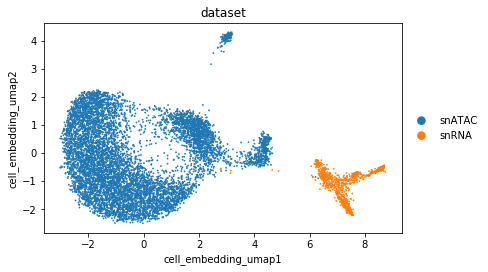

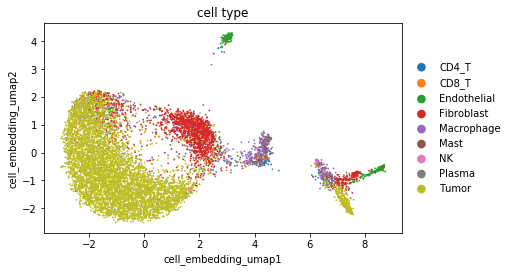

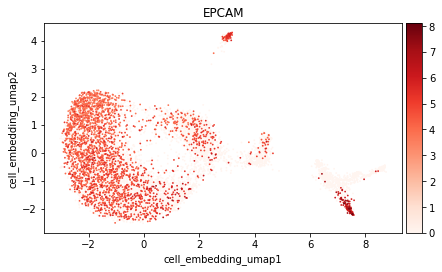

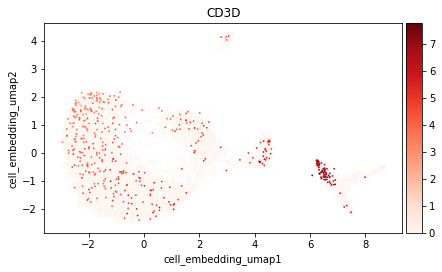

In [36]:
markers = ['EPCAM', 'CD3D']
variables = ['dataset', 'sample_id', 'cell_type']
variables += markers
for var in variables:
    if var in combined_adata.var.index or var in combined_adata.obs.columns:
        sc.pl.scatter(combined_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                     frameon=False, color_map='Reds')
        plt.show()


In [37]:
avg_snRNA = np.mean(combined_adata[combined_adata.obs['dataset']=='snRNA'].obsm['cell_embeddings'], axis=0)
avg_snATAC = np.mean(combined_adata[combined_adata.obs['dataset']=='snATAC'].obsm['cell_embeddings'], axis=0)

mean = np.mean(np.asarray([avg_snRNA, avg_snATAC]), axis=0)

snRNA_delta = mean - avg_snRNA
snATAC_delta = mean - avg_snATAC
# delta = avg_snRNA - avg_snATAC


In [38]:
def operation(latent, dataset):
    if dataset == 'snRNA': return latent + snRNA_delta
    if dataset == 'snATAC': return latent + snATAC_delta
    
#     return latent

transformed_embeddings = np.asarray([operation(latent, dataset)
                           for latent, dataset in zip(combined_adata.obsm['cell_embeddings'],
                                                      combined_adata.obs['dataset'])])

combined_adata.obsm['transformed_embeddings'] = transformed_embeddings
combined_adata.obsm['transformed_embeddings_umap'] = umap.UMAP(
    ).fit_transform(combined_adata.obsm['transformed_embeddings'])
combined_adata.obs['transformed_embeddings_umap1'] = combined_adata.obsm['transformed_embeddings_umap'][:, 0]
combined_adata.obs['transformed_embeddings_umap2'] = combined_adata.obsm['transformed_embeddings_umap'][:, 1]

combined_adata

AnnData object with n_obs × n_vars = 9444 × 13936 
    obs: 'DNase_sensitive_region_fragments', 'SCT_snn_res.0.5', 'TSS.enrichment', 'TSS_fragments', 'batch', 'blacklist_ratio', 'blacklist_region_fragments', 'cell_id', 'cell_type', 'chimeric', 'dataset', 'duplicate', 'enhancer_region_fragments', 'high.tss', 'ident', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'nCount_ACTIVITY', 'nCount_RNA', 'nCount_SCT', 'nCount_peaks', 'nFeature_ACTIVITY', 'nFeature_RNA', 'nFeature_SCT', 'nFeature_peaks', 'nucleosome_group', 'nucleosome_percentile', 'nucleosome_signal', 'on_target_fragments', 'orig.ident', 'passed_filters', 'pct_reads_in_peaks', 'peak_region_cutsites', 'peak_region_fragments', 'peaks_snn_res.0.8', 'percent.mito', 'predicted.id', 'prediction.score.CD4_T', 'prediction.score.CD8_T', 'prediction.score.Endothelial', 'prediction.score.Fibroblast', 'prediction.score.Macrophage', 'prediction.score.Mast', 'prediction.score.NK', 'prediction.score.Plasma', 'prediction.score.Tumor', 'predict

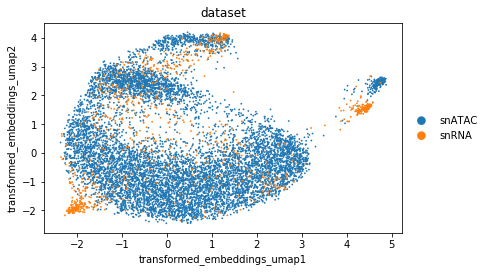

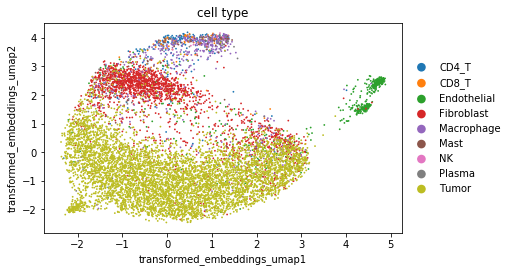

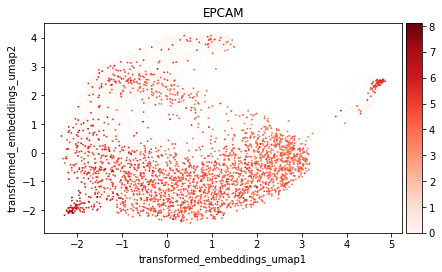

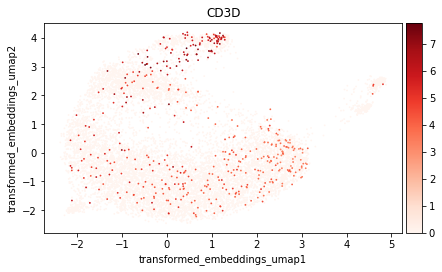

In [39]:
variables = ['dataset', 'cell_type']
variables += markers
for var in variables:
    if var in combined_adata.var.index or var in combined_adata.obs.columns:
        sc.pl.scatter(combined_adata, x='transformed_embeddings_umap1',
                      y='transformed_embeddings_umap2', color=var,
                      frameon=False, color_map='Reds')
        plt.show()